<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Financial Data Labeling
    </h1>
  </div>  
</div>

This notebook demonstrates how to label financial time series data using the `RiskLabAI` library.

We will perform the following steps:

* Load and process daily financial data from FRED (WTI Crude Oil and Bitcoin).
* Calculate and plot daily log-return volatility using **Plotly**.
* Sample events using the CUSUM filter (both fixed and dynamic thresholds).
* Apply the Triple-Barrier Method to label events.
* Generate binary labels for a primary model (meta-labeling).
* Plot a histogram of label returns using **Matplotlib** and the `publication_plots` utility.
* Demonstrate the Trend-Scanning Labeling method using **Plotly**.

# Preliminaries

## Libraries

In [1]:
# Core libraries
import os
import pandas as pd
import numpy as np
import warnings

# --- Plotting Libraries ---
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# --- Data Loading ---
from fredapi import Fred
from dotenv import load_dotenv

# --- RiskLabAI Imports ---
from RiskLabAI.data.labeling import (
    daily_volatility_with_log_returns, 
    symmetric_cusum_filter, 
    cusum_filter_events_dynamic_threshold,
    vertical_barrier, 
    meta_events, 
    meta_labeling,
    find_trend_using_trend_scanning
)
from RiskLabAI.utils import publication_plots as pub_plots

# Assuming this helper exists in the utils directory and is compatible with Plotly
try:
    from RiskLabAI.utils.update_figure_layout import update_figure_layout
except ImportError:
    print("Warning: 'update_figure_layout' not found. Using default layout.")
    # Define a placeholder function if it's missing, so the notebook doesn't crash
    def update_figure_layout(fig, title, xaxis_title, yaxis_title):
        fig.update_layout(
            title=title,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title
        )
        return fig

# --- Configuration ---

# Load FRED API Key from .env file
load_dotenv()
FRED_API_KEY = os.getenv("FRED_API_KEY")

# To run the code on your computer, register for a free FRED API and uncomment the following line
# FRED_API_KEY = 'YOUR_FRED_API_KEY'

if FRED_API_KEY is None:
    print("Warning: FRED_API_KEY not found. Please set it in your .env file or manually.")

# Path to save the Excel file
excel_file_path = "labeling_output.xlsx"

# --- Global Plotting Settings ---
SAVE_PLOTS = False
PLOT_THEME = 'dark' # Options: 'light', 'medium', 'dark'
PLOT_QUALITY = 300 
SAVE_DIR = 'figs'

# 1. Setup Matplotlib using pub_plots (This is for plt figs)
pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

# 2. Setup Plotly theme (This is for px and go figs)
if 'dark' in PLOT_THEME:
    pio.templates.default = "plotly_dark"
elif 'light' in PLOT_THEME:
    pio.templates.default = "plotly_white"
else:
    pio.templates.default = "plotly"

# 3. Ensure the save directory exists if we are saving
if SAVE_PLOTS:
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"Plot saving enabled. Saving to: '{SAVE_DIR}'")
else:
    print("Plot saving disabled.")

# Set pandas and numpy options
warnings.filterwarnings("ignore")
pd.options.plotting.backend = "plotly"
np.seterr(divide='ignore', invalid='ignore')

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.
Plot saving disabled.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Data Import and Initial Processing

### WTI Crude Oil Data (from FRED)

In [2]:
fred = Fred(api_key=FRED_API_KEY)

# Fetch WTI Crude Oil prices
close = fred.get_series('DCOILWTICO', start='2010-01-01', end='2023-12-31')
close = close.dropna()
close.name = 'close'

print(f"Loaded {close.shape[0]} data points for WTI Crude Oil.")
close.head()

Loaded 10035 data points for WTI Crude Oil.


1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
Name: close, dtype: float64

### Bitcoin Data (from FRED)

In [3]:
# Fetch Bitcoin prices
btc = fred.get_series('CBBTCUSD', start='2017-01-01', end='2023-12-31')
btc = btc.dropna()
btc.name = 'Close'

print(f"Loaded {btc.shape[0]} data points for Bitcoin.")
btc.head()

Loaded 3968 data points for Bitcoin.


2014-12-01    370.0
2014-12-02    378.0
2014-12-03    378.0
2014-12-04    377.1
2014-12-06    378.0
Name: Close, dtype: float64

# Analytics (using Plotly)

## Volatility Computation and Plotting

First, we compute the daily log-return volatility, which will serve as the basis for our dynamic CUSUM filter and the width of our triple-barrier.

In [4]:
# Compute daily volatility
vol_series = daily_volatility_with_log_returns(close, span=32)

# Calculate log returns for comparison
rets = np.log(close).diff()

# Combine into a single DataFrame
vol = pd.DataFrame({'rets': rets, 'std': vol_series})
vol = vol.dropna()

vol.head()

,rets,std
1986-01-07,-0.025966,0.018360
1986-01-08,0.000773,0.022689
1986-01-09,0.006166,0.019167
1986-01-10,-0.014706,0.016671
1986-01-13,-0.022473,0.016922


In [5]:
# Snippet 3-1: Plotting returns and volatility (with Plotly)
fig = go.Figure()
fig.add_trace(go.Scatter(x=vol.index, y=vol['rets'].values, mode="lines", marker=dict(color='firebrick'), name="Log Returns"))
fig.add_trace(go.Scatter(x=vol.index, y=vol['std'].values, mode="lines", marker=dict(color='royalblue'), name="Volatility (std)"))
fig.add_trace(go.Scatter(x=vol.index, y=-vol['std'].values, mode="lines", marker=dict(color='royalblue'), name="-Volatility (std)"))

# Apply custom layout
update_figure_layout(fig, "Returns and Volatility", "Date", "Values")

# Finalize plot: Save if enabled, then show
filename = "labeling_01_volatility_plot.png"
if SAVE_PLOTS:
    full_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(full_path, width=1200, height=700) 
    print(f"Figure saved to: {full_path}")

fig.show()

## Fixed Threshold CUSUM Filter

We use the symmetric CUSUM filter to sample events based on a fixed price change. Here, we set the threshold to $5, meaning we sample an event every time the cumulative price change (up or down) exceeds $5.

In [6]:
# Get events using a fixed CUSUM filter
fixed_threshold = 5.0
timeevents_fixed = symmetric_cusum_filter(close, fixed_threshold)

# Plotting the time events (with Plotly)
fig = close.plot(title=f"Fixed CUSUM Events (Threshold = ${fixed_threshold})")
fig.add_trace(go.Scatter(x=timeevents_fixed, y=close[timeevents_fixed], mode="markers", name="tEvents", marker=dict(color='red')))
update_figure_layout(fig, f"Fixed CUSUM Events (Threshold = ${fixed_threshold})", "Date", "Price")

# Finalize plot: Save if enabled, then show
filename = "labeling_02_fixed_cusum_events.png"
if SAVE_PLOTS:
    full_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(full_path, width=1200, height=700) 
    print(f"Figure saved to: {full_path}")

fig.show()

## Dynamic Threshold CUSUM Filter

A fixed threshold may not be appropriate in all market regimes. We can instead use a dynamic threshold based on the series' rolling volatility. Here, we use the rolling standard deviation of **price changes** (not log returns) as our threshold.

In [7]:
# Create a dynamic threshold: 3x rolling 30-day stdev of price *changes*
dynamic_threshold = close.diff().rolling(window=30).std() * 3
dynamic_threshold = dynamic_threshold.dropna()

# Get events using the dynamic threshold CUSUM filter
timeevents_dynamic = cusum_filter_events_dynamic_threshold(close, dynamic_threshold)

# Plotting the time events (with Plotly)
fig = close.plot(title="Dynamic CUSUM Events (3x Rolling Std)")
fig.add_trace(go.Scatter(x=timeevents_dynamic, y=close[timeevents_dynamic], mode="markers", name="Dynamic tEvents", marker=dict(color='cyan')))
update_figure_layout(fig, "Dynamic CUSUM Events (3x Rolling Std)", "Date", "Price")

# Finalize plot: Save if enabled, then show
filename = "labeling_03_dynamic_cusum_events.png"
if SAVE_PLOTS:
    full_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(full_path, width=1200, height=700) 
    print(f"Figure saved to: {full_path}")

fig.show()

## Triple-Barrier Method & Meta-Labeling

Now we apply the triple-barrier method to the events generated by our **dynamic CUSUM filter**. We will use the daily log-return volatility (`vol['std']`) to set the width of the horizontal barriers.

In [8]:
# 1. Select the events to use (we'll use the dynamic ones)
time_events = timeevents_dynamic

# 2. Get the volatility at the event times
stds = vol['std'] # Use log-return vol for barrier width

# 3. Create the vertical barrier (e.g., 21 business days)
t1 = vertical_barrier(close, time_events, 21)

# 4. Set barrier multipliers [Profit-Take, Stop-Loss]
ptsl = [1, 1]

# 5. Run meta_events to get the first barrier touch time
# We filter for events with a minimum volatility of 0.04 (4%)
events = meta_events(
    close,
    time_events,
    ptsl=ptsl,
    target=stds,
    return_min=0.04,
    num_threads=1, # Use 1 for simplicity, increase for speed
    vertical_barrier_times=t1,
    side=None # Assumes long-only (Side=1)
)

events.head()

,End Time,Base Width
1986-02-21,1986-02-24,0.059768
1986-03-03,1986-03-06,0.064963
1986-03-27,1986-03-31,0.077494
1986-04-04,1986-04-07,0.082932
1986-04-16,1986-04-21,0.081277


### Plotting a Single Triple-Barrier Event (with Plotly)

In [9]:
# Plot a single barrier example
# Get barrier widths (ptsl[0] * Base Width)
pt = events['Base Width']
sl = events['Base Width']
upper_barrier = close[events.index] * (1 + pt)
lower_barrier = close[events.index] * (1 - sl)

# Select an event to plot (e.g., the 5th event)
i = 5
event_start_time = events.index[i]
event_end_time = t1.loc[event_start_time] # Vertical barrier
first_touch_time = events['End Time'].iloc[i] # First barrier touched

# Handle potential NaT in first_touch_time (if no barrier was hit)
if pd.isna(first_touch_time):
    print(f"Event {i} did not touch a barrier.")
    first_touch_time = event_end_time # Default to vertical barrier time

# Ensure we have valid times to plot
if pd.isna(event_start_time) or pd.isna(event_end_time):
    print(f"Skipping plot for event {i} due to NaT in barriers.")
else:
    price_touch = close.loc[first_touch_time]
    u_barrier = upper_barrier.iloc[i]
    l_barrier = lower_barrier.iloc[i]

    # Plot the price, barriers, and first touch
    fig = close.plot()

    # Add barrier lines
    fig.add_shape(type="line", x0=event_start_time, y0=u_barrier, x1=event_end_time, y1=u_barrier, line=dict(color="green", width=2, dash='dash'), name="Upper Barrier")
    fig.add_shape(type="line", x0=event_start_time, y0=l_barrier, x1=event_end_time, y1=l_barrier, line=dict(color="red", width=2, dash='dash'), name="Lower Barrier")
    fig.add_shape(type="line", x0=event_end_time, y0=l_barrier, x1=event_end_time, y1=u_barrier, line=dict(color="gray", width=2, dash='dash'), name="Vertical Barrier")

    # Add start and end points
    fig.add_trace(go.Scatter(x=[event_start_time], y=[close.loc[event_start_time]], mode="markers", name="Event Start", marker=dict(size=12, color='blue')))
    fig.add_trace(go.Scatter(x=[first_touch_time], y=[price_touch], mode="markers", name="First Touch", marker=dict(size=12, color='yellow', symbol='x')))

    # Apply custom layout
    update_figure_layout(fig, "Triple Barrier Visualization", "Date", "Price")
    fig.update_xaxes(range=[event_start_time - pd.Timedelta(days=5), event_end_time + pd.Timedelta(days=5)])

    # Finalize plot: Save if enabled, then show
    filename = "labeling_04_triple_barrier_viz.png"
    if SAVE_PLOTS:
        full_path = os.path.join(SAVE_DIR, filename)
        fig.write_image(full_path, width=1200, height=700) 
        print(f"Figure saved to: {full_path}")
    
    fig.show()

### Generating Meta-Labels

In [10]:
# Snippet 3.7: Generate returns and labels from the events
labels = meta_labeling(events, close)
labels.head()

,End Time,Return,Label
1986-02-21,1986-02-24,0.074213,1.0
1986-03-03,1986-03-06,0.091661,1.0
1986-03-27,1986-03-31,-0.101940,-1.0
1986-04-04,1986-04-07,0.121002,1.0
1986-04-16,1986-04-21,0.081780,1.0


### Filtering Rare Labels (Snippet 3.8)

Models can be biased by labels that occur very infrequently. We can define a helper function to drop labels that don't meet a minimum frequency.

In [11]:
def drop_label(events: pd.DataFrame, percent_min: float) -> pd.DataFrame:
    """Filters out labels that are not frequent enough."""
    label_counts = events['Label'].value_counts(normalize=True)
    rare_labels = label_counts[label_counts < percent_min].index
    filtered_events = events[~events['Label'].isin(rare_labels)]
    return filtered_events

# Filter labels that appear less than 5% of the time
filtered_labels = drop_label(labels, percent_min=0.05)

print(f"Original label counts:\n{labels['Label'].value_counts(normalize=True)}")
print("---")
print(f"Filtered label counts:\n{filtered_labels['Label'].value_counts(normalize=True)}")

filtered_labels.head(10)

Original label counts:
Label
 1.0    0.574074
-1.0    0.425926
Name: proportion, dtype: float64
---
Filtered label counts:
Label
 1.0    0.574074
-1.0    0.425926
Name: proportion, dtype: float64


,End Time,Return,Label
1986-02-21,1986-02-24,0.074213,1.0
1986-03-03,1986-03-06,0.091661,1.0
1986-03-27,1986-03-31,-0.101940,-1.0
1986-04-04,1986-04-07,0.121002,1.0
1986-04-16,1986-04-21,0.081780,1.0
1986-04-25,1986-05-08,0.098308,1.0
1986-05-08,1986-05-19,0.087171,1.0
1986-05-27,1986-06-02,-0.090026,-1.0
1986-06-04,1986-06-20,0.093580,1.0
1986-06-20,1986-06-25,-0.087515,-1.0


# Matplotlib Demonstration

Here we will use the `publication_plots` utility to create a publication-quality histogram of the returns from our labeled events. This demonstrates the correct use of the `pub_plots` module with a Matplotlib figure.

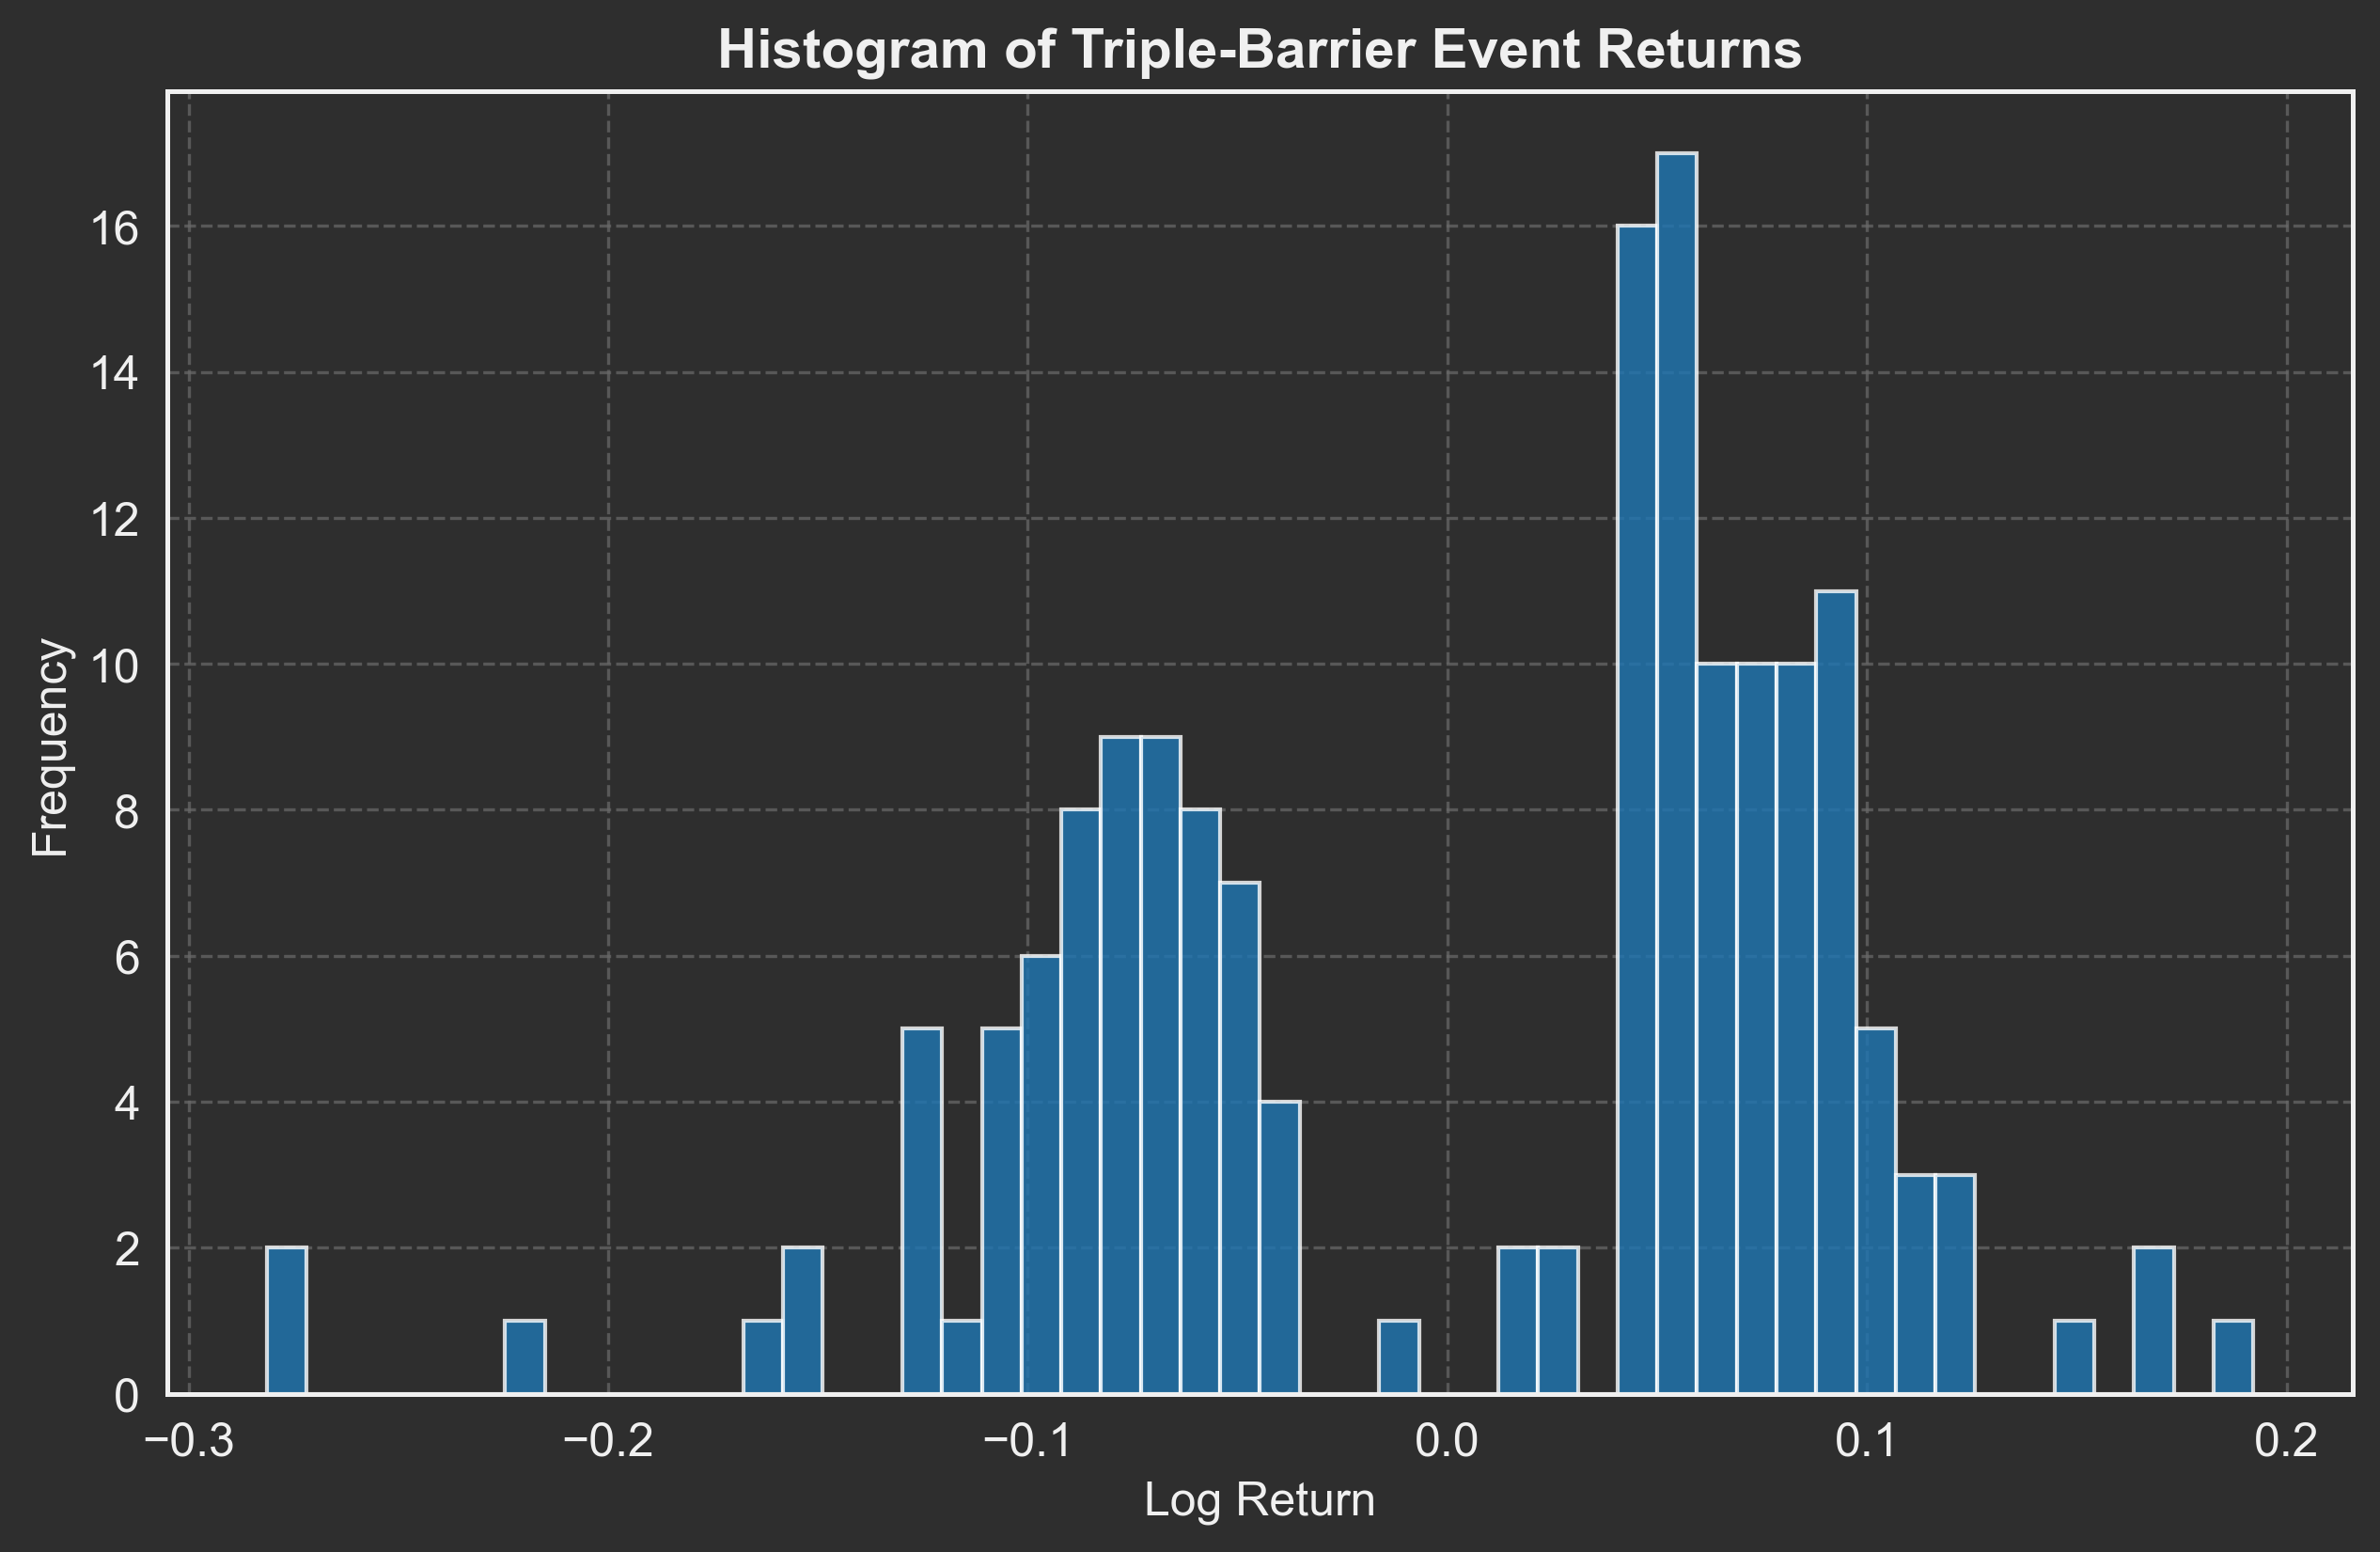

In [12]:
# 1. Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Plot the histogram of returns
ax.hist(labels['Return'].dropna(), bins=50, alpha=0.8, label="Returns")

# 3. Apply the custom publication style
pub_plots.apply_plot_style(
    ax,
    title='Histogram of Triple-Barrier Event Returns',
    xlabel='Log Return',
    ylabel='Frequency'
)

# 4. Finalize the Matplotlib plot (shows and saves if enabled)
pub_plots.finalize_plot(fig, 'labeling_07_matplotlib_histogram.png')

## Trend Scanning Method (using Plotly)

Finally, we demonstrate the trend-scanning method on the Bitcoin (BTC-USD) data. This method labels events based on the most significant trend (highest absolute t-value) found within a range of forward-looking windows.

In [13]:
# Find trends. Scan windows from 3 days to 10 days.
trends = find_trend_using_trend_scanning(btc.index, btc, span=(3, 10))
trends = pd.concat([trends, btc], axis=1).dropna()
trends.head()

,End Time,t-Value,Trend,Close
2014-12-01,2015-01-08,-3.286176,-1.0,370.0
2014-12-02,2015-01-13,-4.728361,-1.0,378.0
2014-12-03,2015-01-14,-5.276015,-1.0,378.0
2014-12-04,2015-01-15,-6.231108,-1.0,377.1
2014-12-06,2015-01-16,-10.705979,-1.0,378.0


In [14]:
# Plot the identified trends (1 for up, -1 for down) (with Plotly)
trends['Trend'] = trends['Trend'].astype(int)
fig = px.scatter(trends, y='Close', color='Trend') 
update_figure_layout(fig, 'Trend Scanning Labels (BTC-USD)', 'Date', 'BTC-USD Price')

# Finalize plot: Save if enabled, then show
filename = "labeling_05_trend_scanning_labels.png"
if SAVE_PLOTS:
    full_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(full_path, width=1200, height=700) 
    print(f"Figure saved to: {full_path}")

fig.show()

In [15]:
# Plot the t-Values to see the *significance* of the trend (with Plotly)
trends['t-Value'] = trends['t-Value'].astype('float64')
fig = px.scatter(trends, y='Close', color='t-Value', color_continuous_scale=px.colors.sequential.Viridis) 
update_figure_layout(fig, 'Trend Scanning T-Values (BTC-USD)', 'Date', 'BTC-USD Price')

# Finalize plot: Save if enabled, then show
filename = "labeling_06_trend_scanning_tvalues.png"
if SAVE_PLOTS:
    full_path = os.path.join(SAVE_DIR, filename)
    fig.write_image(full_path, width=1200, height=700) 
    print(f"Figure saved to: {full_path}")

fig.show()

## Save All Results

In [16]:
# --- Save all results to Excel ---
print(f"Saving all results to {excel_file_path}...")

try:
    with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
        close.to_frame().to_excel(writer, sheet_name='WTI_Close')
        btc.to_frame().to_excel(writer, sheet_name='BTC_Close')
        vol.to_excel(writer, sheet_name='WTI_Volatility')
        pd.DataFrame(timeevents_fixed, columns=['Timestamp']).to_excel(writer, sheet_name='Fixed_CUSUM_Events')
        pd.DataFrame(timeevents_dynamic, columns=['Timestamp']).to_excel(writer, sheet_name='Dynamic_CUSUM_Events')
        events.to_excel(writer, sheet_name='TripleBarrier_Events')
        labels.to_excel(writer, sheet_name='TripleBarrier_Labels')
        filtered_labels.to_excel(writer, sheet_name='Filtered_Labels')
        trends.to_excel(writer, sheet_name='Trend_Scanning_Labels')
    print(f"All data saved successfully to {excel_file_path}")
except Exception as e:
    print(f"Error saving to Excel: {e}")
    print(f"Make sure the file '{excel_file_path}' is not open.")

Saving all results to labeling_output.xlsx...
Error saving to Excel: No module named 'xlsxwriter'
Make sure the file 'labeling_output.xlsx' is not open.
